# Projeto Final: popularidade de músicas no Spotify

Esse projeto busca utilizar dados disponibilizados pelo Spotify para prever a popularidade das músicas na plataforma.

O Spotify é a maior plataforma de _streaming_ de música atual. Além da enorme quantidade de dados gerados pelos seus usuários, o Spotify possui também muitos metadados desenvolvidos a partir da análise das músicas. Como veremos, temos variáveis como _danceability_, que consiste em uma medida de quão dançavel é certa música.

Dentre essas informações disponibilizadas destacamos a popularidade da música, que nesse projeto será considerada como alvo. Assim, nosso modelo tentará "advinhar" as próximas músicas populares. Para manter o problema geral, foram mantidas praticamente todas as variáveis, porém um algoritmo que tivesse como único objetivo prever qual música será o próximo sucesso poderia desconsiderar o ano da música, apesar da possibilidade de um retorno de alguma música, há uma clara relação entre a popularidade e o ano, um vez que a popularidade da música é a medida instântanea da música, e não uma popularidade na época do lançamento. 

Embora o objetivo do problema seja classificar a popularidade de músicas, o conjunto de dados contém também _podcasts_, _audiobooks_ e poesias. Uma abordagem possível seria tentar distinguir esses elementos e removê-los do conjunto de dados, assim tratando apenas de músicas. Como será visto mais adiante, os dados incluem informações que torna possível filtrar o _dataset_. Por outro lado, é possível também não distinguí-los das músicas, já que em ambos o algoritmo simplesmente buscará determinar a popularidade. 

Por fim, como mencionado anteriomente, os dados contém tanto aspectos objetivos das músicas (como a duração ou o ano de lançamento) quanto outros que são estimados pelo próprio Spotify. Embora ambos sejam úteis para o nosso modelo, a qualidade das informações estimadas pelo Spotify acaba sendo uma limitação para o modelo, visto que é praticamente impossível tratá-los, sendo necessário assumí-los como razoáveis. 

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    print("\nScores:", scores) 

#se quiser o tempo de execução de cada célula no colab:
#!pip install ipython-autotime
#%load_ext autotime

In [ ]:
# Controle de versão

seed = 1701
np.random.seed(seed)  

time: 1.57 ms (started: 2021-02-09 22:53:45 +00:00)


In [ ]:
# Configuração das figuras

%matplotlib inline 

mpl.rc('axes', labelsize=14) 
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

time: 5.72 ms (started: 2021-02-09 22:53:45 +00:00)


In [ ]:
# Ignorar warnings desnecessários (ver SciPy issue #5998)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

time: 2.23 ms (started: 2021-02-09 22:53:45 +00:00)


## **Load Data**

In [ ]:
url1 = "https://raw.githubusercontent.com/TadeuNP/MLSC/main/data_part1.csv?token=AO7PK5OBMKJJLUF3F3ES7RDAEWGHI"
url2 = "https://raw.githubusercontent.com/TadeuNP/MLSC/main/data_part2.csv?token=AO7PK5IKI2YAU2BK2HFV4SLAEWGSA"

temp_data_1 = pd.read_csv(url)
temp_data_2 = pd.read_csv(url2)

prep_df = pd.concat([temp_data_1, temp_data_2])

print(len(prep_df))
prep_df

174389


acousticness                             artists  ...  valence  year
0          0.991000                     ['Mamie Smith']  ...   0.6340  1920
1          0.643000           ["Screamin' Jay Hawkins"]  ...   0.9500  1920
2          0.993000                     ['Mamie Smith']  ...   0.6890  1920
3          0.000173                 ['Oscar Velazquez']  ...   0.0422  1920
4          0.295000                            ['Mixe']  ...   0.2990  1920
...             ...                                 ...  ...      ...   ...
74384      0.009170  ['DJ Combo', 'Sander-7', 'Tony T']  ...   0.1860  2020
74385      0.795000                    ['Alessia Cara']  ...   0.2280  2021
74386      0.806000                       ['Roger Fly']  ...   0.7140  2020
74387      0.920000                    ['Taylor Swift']  ...   0.3200  2021
74388      0.239000                       ['Roger Fly']  ...   0.7470  2020

[174389 rows x 19 columns]

In [ ]:
temp_data_1 = pd.read_csv('/content/data_part1.csv')
temp_data_2 = pd.read_csv('/content/data_part2.csv')

time: 733 ms (started: 2021-02-09 22:53:45 +00:00)


In [ ]:
prep_df = pd.concat([temp_data_1, temp_data_2])

len(prep_df)

174389

time: 53.9 ms (started: 2021-02-09 22:53:46 +00:00)


In [ ]:
prep_df.head()

acousticness                    artists  ...  valence  year
0      0.991000            ['Mamie Smith']  ...   0.6340  1920
1      0.643000  ["Screamin' Jay Hawkins"]  ...   0.9500  1920
2      0.993000            ['Mamie Smith']  ...   0.6890  1920
3      0.000173        ['Oscar Velazquez']  ...   0.0422  1920
4      0.295000                   ['Mixe']  ...   0.2990  1920

[5 rows x 19 columns]

time: 52.7 ms (started: 2021-02-09 22:53:46 +00:00)


# **1 - Descrição do conjunto de dados**

Descrição das *features*:

1. Acousticness: Quanto mais próximo de 1 maior a confiança de que a música é acústica. 

2. Artists: Artista da música

3. Danceability: Indica quão dançável a música é. É estabelecido considerando características particulares da música.

4. Duration_ms: Duração da música em milissegundos. 

5. Energy: Valor num intervalo de 0 até 1. Indica a "intensidade" da música.

6. Explicit: Variável booleana que indica se a música contém conteúdo explícito (1) ou não (0).

7. ID: um código interno do Spotify para identificar as músicas. 

8. Instrumentalness: Uma probabilidade de que a música é instrumental. Quanto mais próximo de 1.0, maior a confiança de que não há qualquer conteúdo vocal na faixa.

9. Key: Tom da música. Exemplo: 0 = C, 1 = C♯/D♭, etc. ([*Pitch Class notation*](https://en.wikipedia.org/wiki/Pitch_class))

10. Liveness: Probabilidade de música ser performada ao vivo.

11. Loudness: Valor referente ao barulho médio da música, em decibeis (dB)

12. Mode: Tipo de escala em que a música está. Maior = 1. Menor = 0.

13. Name: Nome da música

14. Popularity: Popularidade da faixa. Intervalo de 0 a 100, em que 100 é o máximo de popularidade. Considera não apenas o número total de vezes que a música foi ouvida mas também a popularidade recente.

15. Release_date: Data de lançamento da música

16. Speechiness: Razão de barulhos do tipo de voz, usados para separar podcasts, audio books, poesia entre outros. Um valor acima de 0.66 representa algo provavelmente feito apenas de palavras ditas. Valores entre 0.33 e 0.66 representam músicas com musicas e palvras ditas, por exemplo rap. Valores abaixo de 0.33 são provavelmente músicas sem trechos com palavras ditas.

17. Tempo: O andamento da música em BPM (*beats per minute*)

18. Valence: Uma medida de 0 a 1 de quão "positiva" a música é. Valores próximos de 1 são atribuídos a músicas "alegres".

19. Year: Ano em que a música foi lançada



Para obter informações mais detalhadas: https://developer.spotify.com/documentation/web-api/reference/



Vamos checar algumas informações sobre esse *dataset*:

In [ ]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174389 entries, 0 to 74388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             174

Não há dados faltantes. Além disso, nossos dados são *floats*, *ints* e *strings*.

Sendo mais específico:

  - As *features* "mode" e "explicit" são categóricas, com dois possíveis valores. Já "key" tem 12 valores possíveis.
  - "artists", "name" e "id" contém texto. 
  - "year" contém algum valor inteiro no intervalo [1920, 2021].
  -  todas as outras *features* são quantativas e contínuas; a maioria entre 0 e 1.

In [ ]:
prep_df.describe()

acousticness   danceability  ...        valence           year
count  174389.000000  174389.000000  ...  174389.000000  174389.000000
mean        0.499228       0.536758  ...       0.524533    1977.061764
std         0.379936       0.176025  ...       0.264477      26.907950
min         0.000000       0.000000  ...       0.000000    1920.000000
25%         0.087700       0.414000  ...       0.311000    1955.000000
50%         0.517000       0.548000  ...       0.536000    1977.000000
75%         0.895000       0.669000  ...       0.743000    1999.000000
max         0.996000       0.988000  ...       1.000000    2021.000000

[8 rows x 15 columns]

time: 172 ms (started: 2021-02-09 22:53:46 +00:00)


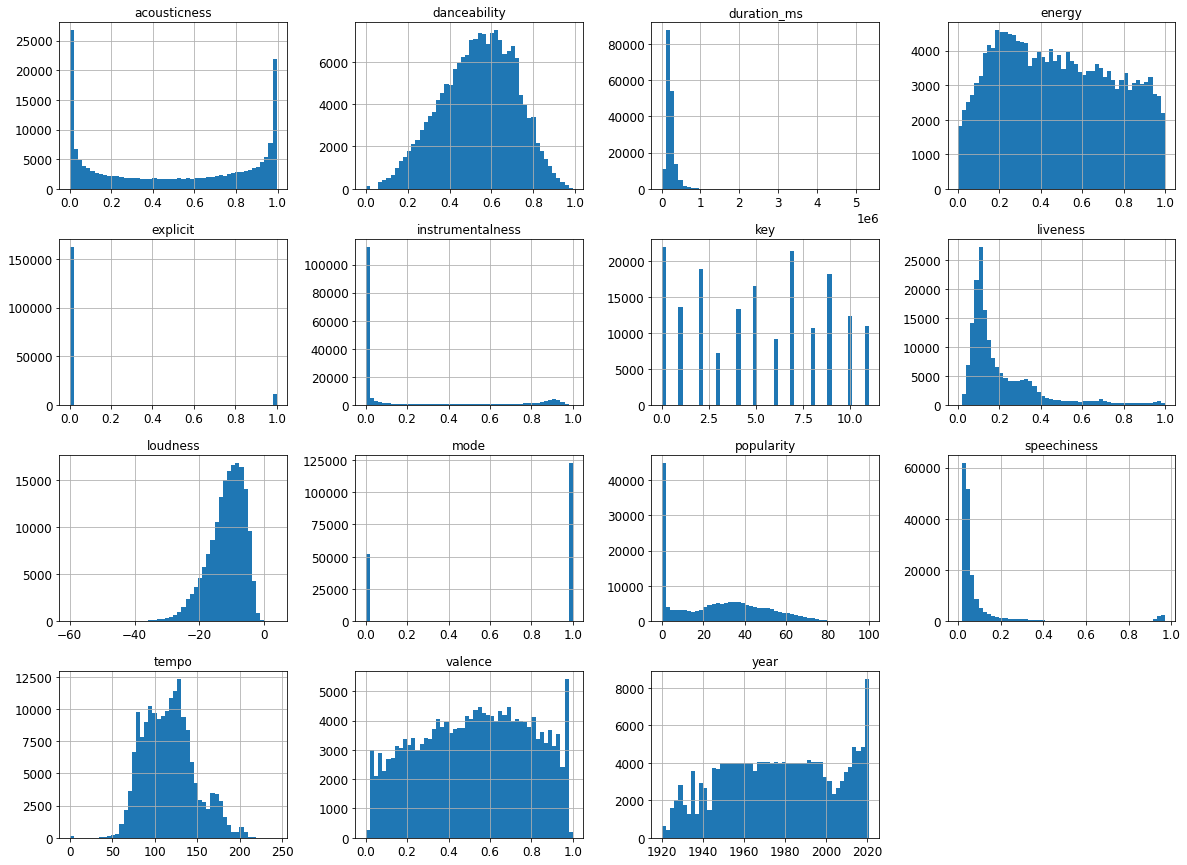

time: 3.54 s (started: 2021-02-09 22:53:46 +00:00)


In [ ]:
prep_df.hist(bins = 50, figsize = (20, 15))
plt.show()

In [ ]:
len(prep_df) - prep_df['id'].nunique()

2159

time: 67 ms (started: 2021-02-09 22:53:50 +00:00)


Temos 2159 observações que não são únicas, vamos verificar.

In [ ]:
prep_df['id'].value_counts()

1xQvPFljQXA3GCK869ERvC    9
0UsmyJDsst2xhX1ZiFF3JW    9
7tJS1cjSD1P8bodNGblYiK    9
7GlixhQpXo76vgALqoJ3L5    8
2pZDhsmGRSkRgWNfkDr70S    8
                         ..
5MimWt53Ukh0gcv7mC0Rnx    1
1j4Mz23w2zw2mRofuaCmbU    1
1tTahkj1JgUDC57PwbNYLg    1
4nxF8uu1grcbSDNo8pwtEm    1
5WkRJfonKEIUgEPmkkqHKl    1
Name: id, Length: 172230, dtype: int64

time: 216 ms (started: 2021-02-09 22:53:50 +00:00)


In [ ]:
#vamos olhar o primeiro dos IDs

prep_df[prep_df["id"] == "0UsmyJDsst2xhX1ZiFF3JW"]

acousticness                artists  danceability  ...   tempo  valence  year
16071         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020
16881         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020
17883         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020
18063         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020
18269         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020
18863         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020
19065         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020
19467         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020
20071         0.969  ['Schoolgirl Byebye']         0.314  ...  69.893    0.161  2020

[9 rows x 19 columns]

time: 66.7 ms (started: 2021-02-09 22:53:50 +00:00)


In [ ]:
len(prep_df[prep_df.duplicated()])

2159

time: 310 ms (started: 2021-02-09 22:53:50 +00:00)


Com isso confirmamos que alguns dados estão duplicados. Podemos removê-los.

In [ ]:
prep_df.drop_duplicates(inplace=True)

time: 314 ms (started: 2021-02-09 22:53:51 +00:00)


In [ ]:
len(prep_df)

172230

time: 3.39 ms (started: 2021-02-09 22:53:51 +00:00)


Antes de prosseguir para a separação das observações, há um outro problema que aparenta necessitar de tratamento: temos duas variáveis relacionadas com data, _year_ e _release_date_.

Poderíamos lidar com essa redundância extraindo informações da variável _release_date_, pois contém meses e dias que podem estar correlacionados com o sucesso das músicas (hits de verão, por exemplo). No caso, como muitas das músicas não contém um registro confiável para as datas, vamos optar apenas por remover a *feature* _release_date_, mantendo apenas a informação acerca dos anos.

Antes de remover a _feature_, vamos ilustrar o problema comentado acima.

In [ ]:
prep_df["release_date"].value_counts()

1945          1447
1949          1234
1948          1172
1935          1105
1926          1059
              ... 
2007-08-14       1
2004-02-23       1
1989-01-27       1
1995-08-11       1
1975-08-20       1
Name: release_date, Length: 11043, dtype: int64

time: 45.1 ms (started: 2021-02-09 22:53:51 +00:00)


Ou seja, há um enorme número de faixas cuja data de lançamento contém apenas o ano, tornando a variável redundante.

In [ ]:
prep_df['release_date']

0              1920
1        1920-01-05
2              1920
3        1920-01-01
4        1920-10-01
            ...    
74379    2021-01-22
74381    2021-01-22
74383    2021-01-22
74385    2021-01-22
74387    2021-01-07
Name: release_date, Length: 172230, dtype: object

time: 6.61 ms (started: 2021-02-09 22:53:51 +00:00)


In [ ]:
prep_df['year']

0        1920
1        1920
2        1920
3        1920
4        1920
         ... 
74379    2021
74381    2021
74383    2021
74385    2021
74387    2021
Name: year, Length: 172230, dtype: int64

time: 6.95 ms (started: 2021-02-09 22:53:51 +00:00)


In [ ]:
prep_df['release_date'] = pd.to_datetime(prep_df['release_date'])
prep_df['release_year'] = pd.DatetimeIndex(prep_df['release_date']).year

prep_df['release_year']

0        1920
1        1920
2        1920
3        1920
4        1920
         ... 
74379    2021
74381    2021
74383    2021
74385    2021
74387    2021
Name: release_year, Length: 172230, dtype: int64

time: 93.8 ms (started: 2021-02-09 22:53:51 +00:00)


In [ ]:
# conferindo se todos os valores possuem o ano igual ao ano da data de lançamento

len(prep_df.loc[prep_df['year'] == prep_df['release_year']])

172230

time: 96.4 ms (started: 2021-02-09 22:53:51 +00:00)


Como a variável ano representa com fidelidade o ano de lançamento torna-se redundante manter as duas variáveis, por uma questão de uniformidade e simplicidade manteremos a variável _year_

In [ ]:
prep_df = prep_df.drop(columns=['release_year'])

time: 29.9 ms (started: 2021-02-09 22:53:51 +00:00)


In [ ]:
prep_df.head()

acousticness                    artists  ...  valence  year
0      0.991000            ['Mamie Smith']  ...   0.6340  1920
1      0.643000  ["Screamin' Jay Hawkins"]  ...   0.9500  1920
2      0.993000            ['Mamie Smith']  ...   0.6890  1920
3      0.000173        ['Oscar Velazquez']  ...   0.0422  1920
4      0.295000                   ['Mixe']  ...   0.2990  1920

[5 rows x 19 columns]

time: 46.2 ms (started: 2021-02-09 22:53:51 +00:00)


# **2 - Separação do conjunto em treino e teste**

Como o objetivo do problema é determinar a popularidade de uma música específica:

- É necessário estratificar a variável alvo, para que haja um número mínimo de observações para cada categoria, tanto no conjunto de treino como no de testes.
- Nesse caso será uma estratificação de 10 em 10 com 10 estratos.

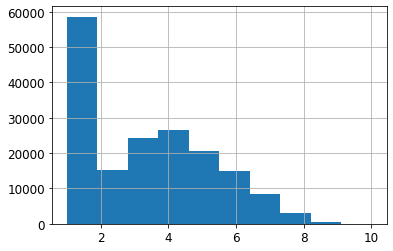

time: 244 ms (started: 2021-02-09 22:53:51 +00:00)


In [ ]:
prep_df['popularity_cat'] = pd.cut(prep_df['popularity'],
                                   bins = [-1, 10., 20., 30., 40., 50., 60., 70., 80., 90., 100], 
                                   labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 

prep_df['popularity_cat'].hist()

In [ ]:
prep_df['popularity_cat'].value_counts()

1     58611
4     26665
3     24370
5     20560
2     15151
6     14820
7      8418
8      3161
9       443
10       31
Name: popularity_cat, dtype: int64

time: 16 ms (started: 2021-02-09 22:53:52 +00:00)


- Realizando a amostragem estratificada com base na nova variável criada, assim como no exemplo do *California Housing*

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in split.split(prep_df, prep_df['popularity_cat']):

    strat_train_set = prep_df.iloc[train_index]
    strat_test_set = prep_df.iloc[test_index]

time: 148 ms (started: 2021-02-09 22:53:52 +00:00)


In [ ]:
prep_df["popularity"].describe()

count    172230.000000
mean         25.925913
std          21.866745
min           0.000000
25%           1.000000
50%          26.000000
75%          42.000000
max         100.000000
Name: popularity, dtype: float64

time: 14.9 ms (started: 2021-02-09 22:53:52 +00:00)


- Testando se a separação está com as categorias bem representadas nos dois conjuntos

In [ ]:
strat_test_set['popularity_cat'].value_counts() / len(strat_test_set)

1     0.340301
4     0.154822
3     0.141497
5     0.119375
2     0.087964
6     0.086048
7     0.048888
8     0.018348
9     0.002584
10    0.000174
Name: popularity_cat, dtype: float64

time: 9.22 ms (started: 2021-02-09 22:53:52 +00:00)


In [ ]:
prep_df['popularity_cat'].value_counts() / len(prep_df)

1     0.340307
4     0.154822
3     0.141497
5     0.119375
2     0.087970
6     0.086048
7     0.048877
8     0.018353
9     0.002572
10    0.000180
Name: popularity_cat, dtype: float64

time: 10.3 ms (started: 2021-02-09 22:53:52 +00:00)


- Remover variável *popularity_cat*, já que é redundante com *popularity* e foi criada apenas para realizar a separação do conjunto de treino e teste.

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("popularity_cat", axis=1, inplace=True)

# acho que esse warning nao importa pra gente 
# strat_test_set.columns parece ter removido a coluna corretamente

time: 54.5 ms (started: 2021-02-09 22:53:52 +00:00)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# **3 - Visualização do conjunto de dados**

In [ ]:
vis_df = strat_train_set.copy()

time: 18.3 ms (started: 2021-02-09 22:53:52 +00:00)


- Visualizar correlações

In [ ]:
corr_matrix = vis_df.corr()

corr_matrix

acousticness  danceability  ...   valence      year
acousticness          1.000000     -0.265132  ... -0.168060 -0.609368
danceability         -0.265132      1.000000  ...  0.540100  0.157773
duration_ms          -0.088918     -0.103498  ... -0.183992  0.106033
energy               -0.750167      0.205534  ...  0.327643  0.543771
explicit             -0.208937      0.204625  ... -0.009861  0.151089
instrumentalness      0.226896     -0.219893  ... -0.215846 -0.127280
key                  -0.026452      0.025698  ...  0.024797  0.019833
liveness             -0.030479     -0.109898  ... -0.005891 -0.010752
loudness             -0.544477      0.250281  ...  0.302723  0.467650
mode                  0.063263     -0.048735  ...  0.020454 -0.047556
popularity           -0.408572      0.128517  ...  0.061471  0.540310
speechiness          -0.024779      0.242107  ...  0.050841 -0.218292
tempo                -0.221306      0.003640  ...  0.163839  0.160672
valence              -0.168060      0.540100  ...  1.000000 -0.046236
year                 -0.609368      0.157773  ... -0.046236  1.000000

[15 rows x 15 columns]

time: 121 ms (started: 2021-02-09 22:53:52 +00:00)


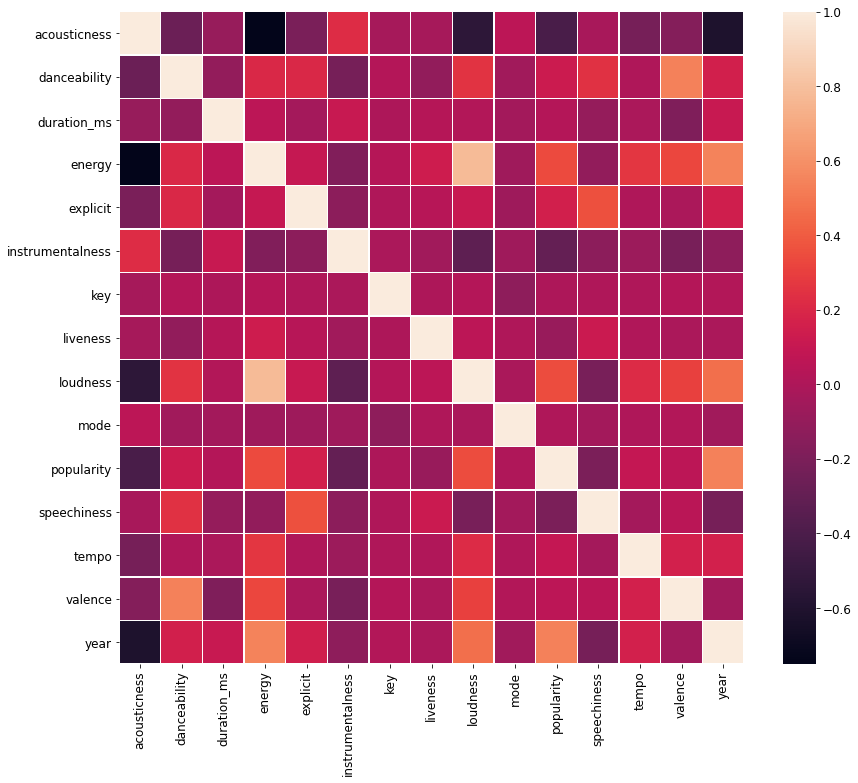

time: 579 ms (started: 2021-02-09 22:53:52 +00:00)


In [ ]:
plt.figure(figsize=(14,12))
ax = sns.heatmap(vis_df.corr(), linewidth=0.5)
plt.show()

Podemos ilustrar as relações entre algumas das _features_ e incluir nos gráficos a informação sobre a variável "_explicit_":

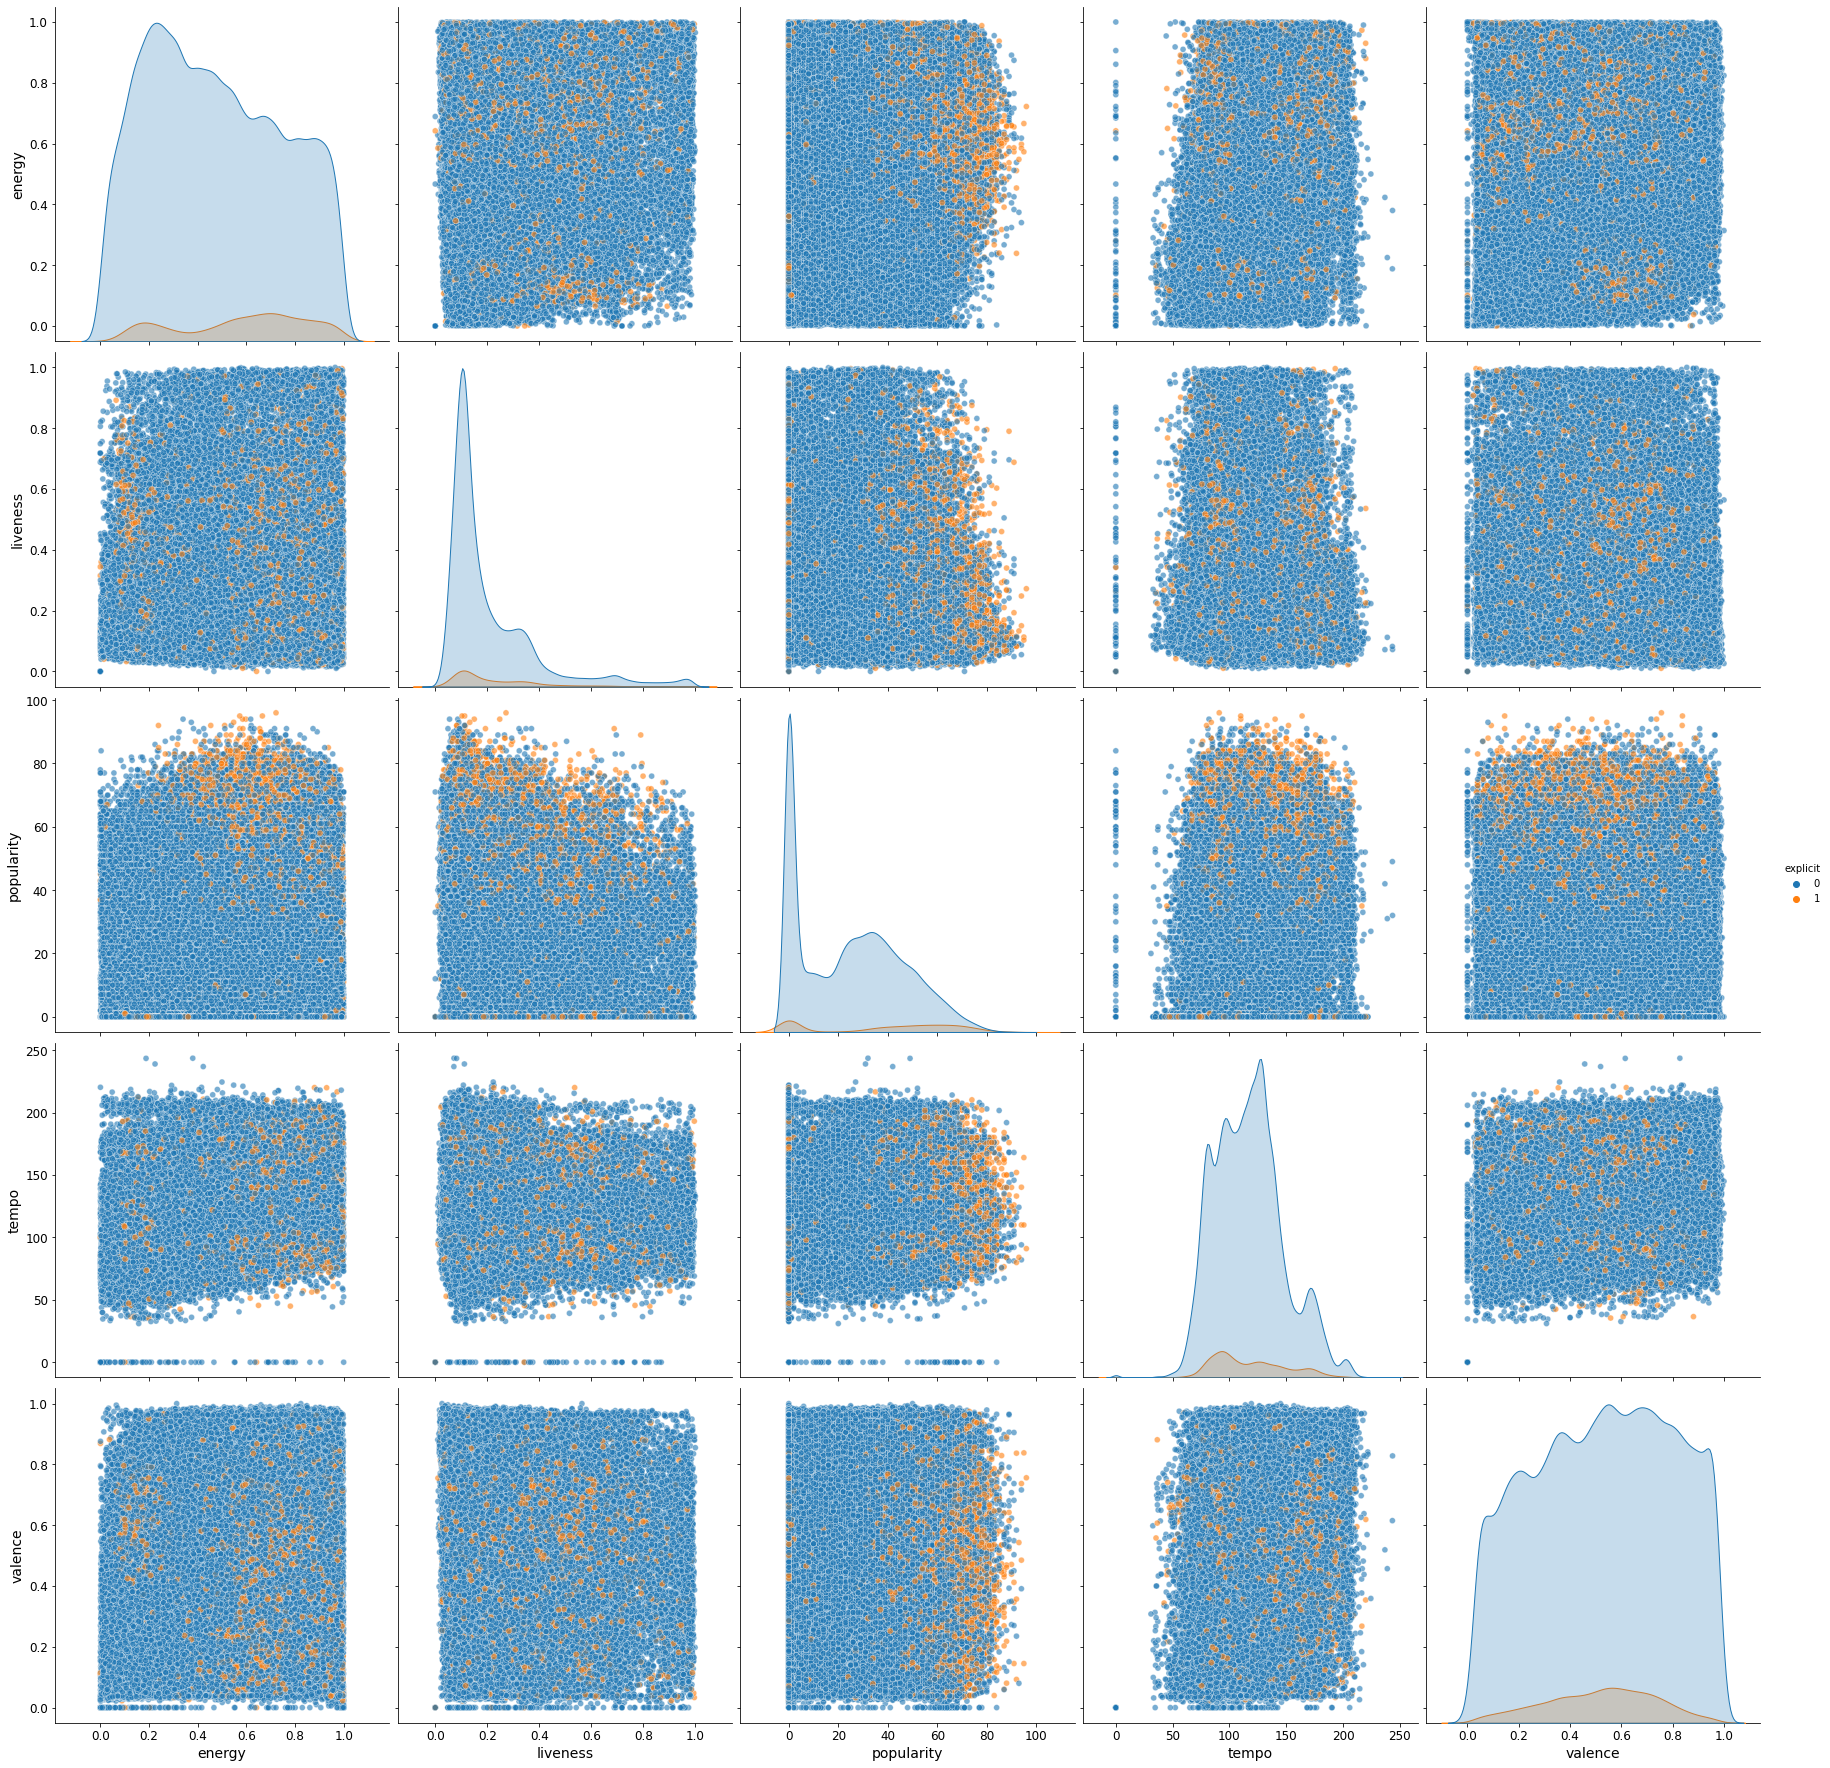

time: 2min 52s (started: 2021-02-09 22:53:53 +00:00)


In [ ]:
features = ["energy", "liveness", "popularity", "tempo", "valence"]

sns.pairplot(vis_df[features+ ["explicit"]], hue="explicit", height=5,  plot_kws=dict(alpha=0.6))  
plt.show()

In [ ]:
corr_matrix['popularity'].sort_values(ascending=False)

popularity          1.000000
year                0.540310
loudness            0.345421
energy              0.340206
explicit            0.155125
danceability        0.128517
tempo               0.096588
valence             0.061471
duration_ms         0.025486
mode                0.002822
key                 0.000451
liveness           -0.080867
speechiness        -0.197119
instrumentalness   -0.298288
acousticness       -0.408572
Name: popularity, dtype: float64

time: 7.41 ms (started: 2021-02-09 22:56:45 +00:00)


- Year:

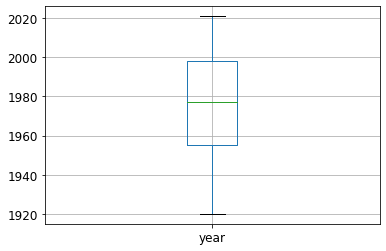

time: 215 ms (started: 2021-02-09 22:56:45 +00:00)


In [ ]:
vis_df.boxplot(column = 'year')

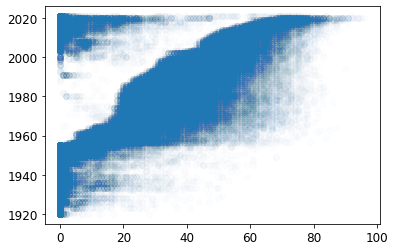

time: 1.04 s (started: 2021-02-09 22:56:45 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['year'], alpha = 0.01)



> Aparenta ter uma relação crescente de popularidade com os anos, porém a partir dos anos 2000 tem um grande número de músicas com baixa popularidade.



- Acousticness:

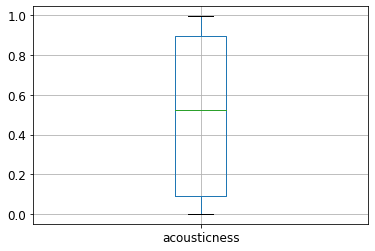

time: 367 ms (started: 2021-02-09 22:56:46 +00:00)


In [ ]:
vis_df.boxplot(column = 'acousticness')

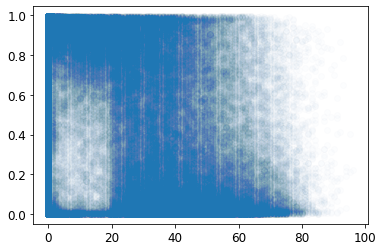

time: 844 ms (started: 2021-02-09 22:56:47 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['acousticness'], alpha = 0.01)

- Loudness:

> Possui uma relação inversa, fazendo-se notar que músicasmenos  acústicas são ligeriamente mais populares.


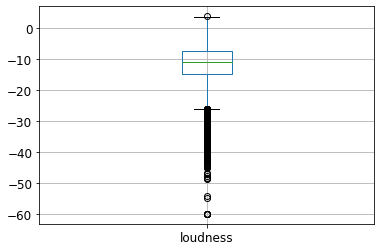

time: 169 ms (started: 2021-02-09 22:56:47 +00:00)


In [ ]:
vis_df.boxplot(column = 'loudness')

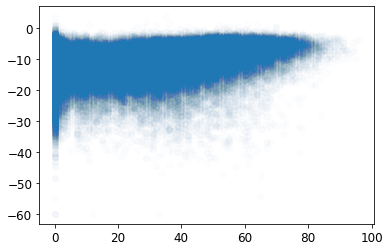

time: 705 ms (started: 2021-02-09 22:56:48 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['loudness'], alpha = 0.01)

> Há uma relação entre mais populares e valores de _loudness_ mais próximos de zero (mais "barulhentas")

- Energy:

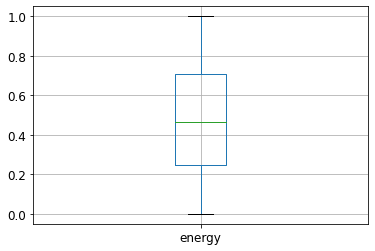

time: 175 ms (started: 2021-02-09 22:56:48 +00:00)


In [ ]:
vis_df.boxplot(column = 'energy')

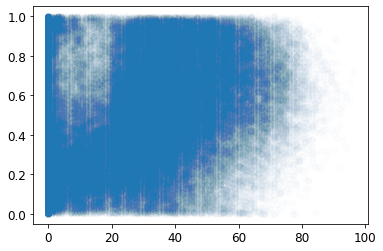

time: 712 ms (started: 2021-02-09 22:56:49 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['energy'], alpha = 0.01)

> Aqui pode-se observar uma leve tendência a músicas com uma "energia" maior, ou seja, mais alegres serem mais populares


- Instrumentalness:

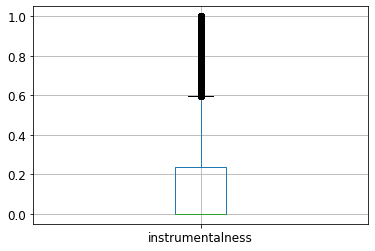

time: 215 ms (started: 2021-02-09 22:56:49 +00:00)


In [ ]:
vis_df.boxplot(column = 'instrumentalness')

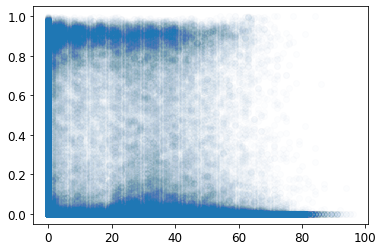

time: 704 ms (started: 2021-02-09 22:56:50 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['instrumentalness'], alpha = 0.01)

> Através destes gráficos é possível perceber que a maioria das músicas são muito instrumentais ou pouco instrumentais, com as que não são tão instrumentais sendo em média mais populares

- Speechiness:

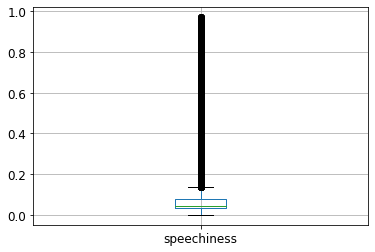

time: 191 ms (started: 2021-02-09 22:56:50 +00:00)


In [ ]:
vis_df.boxplot(column = 'speechiness')

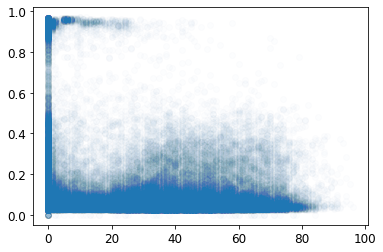

time: 715 ms (started: 2021-02-09 22:56:50 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['speechiness'], alpha = 0.01)

> Aqui foi observada uma grande preferência por valores menores de _speechiness_, que como foi descrito no conjunto de dados abaixo de 0.33 é onde se situam as músicas que não são tão faladas.

- Explicit:

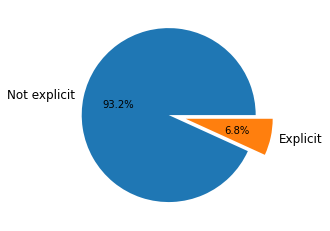

time: 68.4 ms (started: 2021-02-09 22:56:51 +00:00)


In [ ]:
explicit_df = vis_df['explicit'].value_counts()

labels = ['Not explicit', 'Explicit']

plt.pie(explicit_df, explode = (0, 0.2), labels=labels, autopct='%1.1f%%')
plt.show()

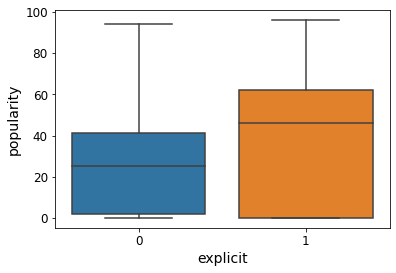

time: 188 ms (started: 2021-02-09 22:56:51 +00:00)


In [ ]:
sns.boxplot(x = 'explicit', y = 'popularity', data = vis_df)

> Há um número muito inferior de músicas explicitas, entretanto elas aparentam ter um pouco mais de popularidade na média


- Danceability:

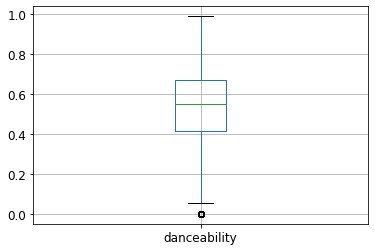

time: 157 ms (started: 2021-02-09 22:56:51 +00:00)


In [ ]:
vis_df.boxplot(column = 'danceability')

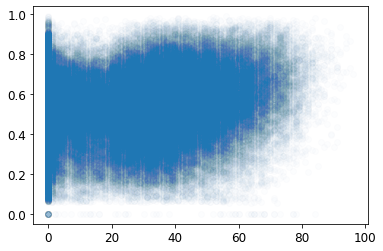

time: 720 ms (started: 2021-02-09 22:56:52 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['danceability'], alpha = 0.01)

> Aparenta ter uma relação crescente com a dançabilidade da música e a sua popularidade.


- Tempo:

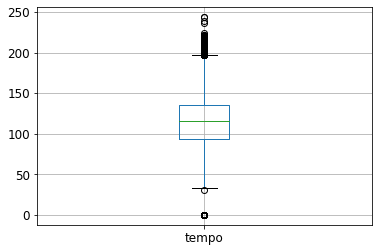

time: 168 ms (started: 2021-02-09 22:56:52 +00:00)


In [ ]:
vis_df.boxplot(column = 'tempo')

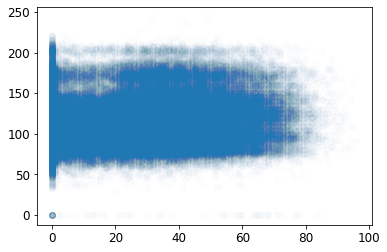

time: 719 ms (started: 2021-02-09 22:56:52 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['tempo'], alpha = 0.01)

> Sendo umas das variáveis numéricas com menor modulo de correlação não é possível atribuir uma tendência


- Liveness:

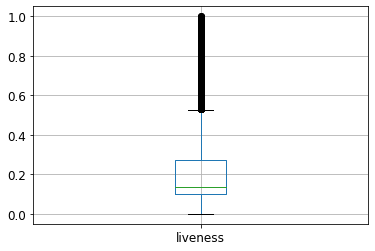

time: 265 ms (started: 2021-02-09 22:56:53 +00:00)


In [ ]:
vis_df.boxplot(column = 'liveness')

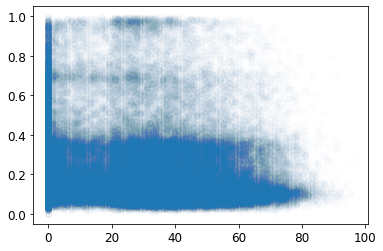

time: 724 ms (started: 2021-02-09 22:56:53 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['liveness'], alpha = 0.01)

> Assim como para a variável anterior não há uma clara relação, porém pode-se observar que há muito mais observações com valor inferior a 0.4 _liveness_


- Valence:

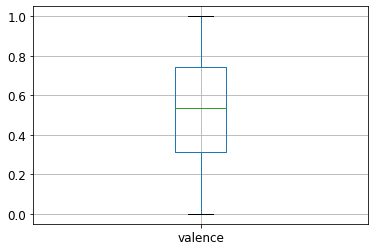

time: 194 ms (started: 2021-02-09 22:56:54 +00:00)


In [ ]:
vis_df.boxplot(column = 'valence')

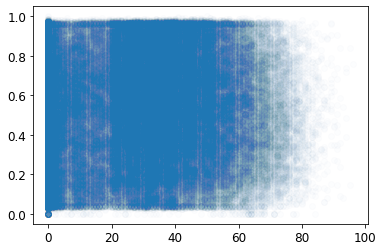

time: 770 ms (started: 2021-02-09 22:56:54 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['valence'], alpha = 0.01)

> Assim como para a variável anterior não há uma clara relação com a popularidade e possui uma dispersão bem homogênea


- Duration_ms:

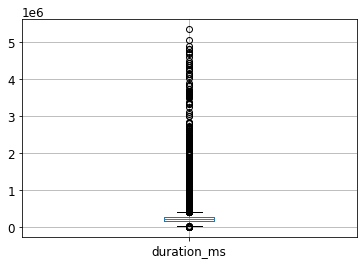

time: 194 ms (started: 2021-02-09 22:56:55 +00:00)


In [ ]:
vis_df.boxplot(column = 'duration_ms')

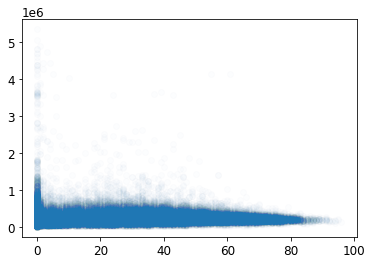

time: 746 ms (started: 2021-02-09 22:56:55 +00:00)


In [ ]:
plt.scatter(x = vis_df['popularity'], y = vis_df['duration_ms'], alpha = 0.01)

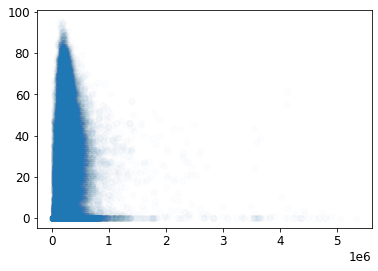

time: 718 ms (started: 2021-02-09 22:56:56 +00:00)


In [ ]:
plt.scatter(x = vis_df['duration_ms'], y = vis_df['popularity'], alpha = 0.01)



> Relacionar com speechiness para talvez filtrar apenas prováveis músicas



- Mode:

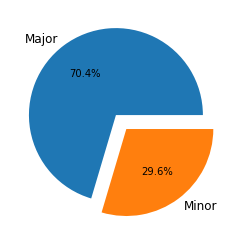

time: 57.3 ms (started: 2021-02-09 22:56:57 +00:00)


In [ ]:
mode_df = vis_df['mode'].value_counts()

labels = ['Major', 'Minor']

plt.pie(mode_df, explode = (0, 0.2), labels=labels, autopct='%1.1f%%')
plt.show()

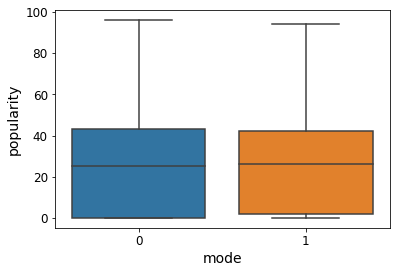

time: 170 ms (started: 2021-02-09 22:56:57 +00:00)


In [ ]:
sns.boxplot(x = 'mode', y = 'popularity', data = vis_df)

- Key:

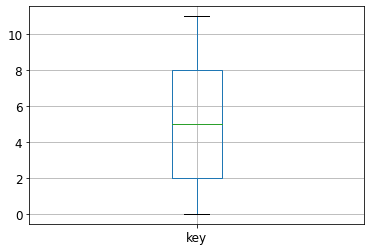

time: 142 ms (started: 2021-02-09 22:56:57 +00:00)


In [ ]:
vis_df.boxplot(column = 'key')

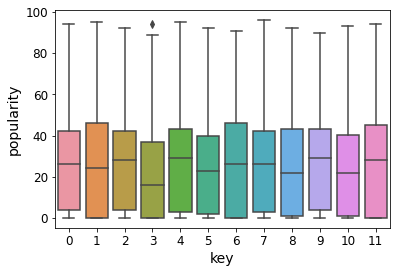

time: 341 ms (started: 2021-02-09 22:56:57 +00:00)


In [ ]:
sns.boxplot(x = 'key', y = 'popularity', data = vis_df)


# **4 - Preparação do conjunto de dados**

In [ ]:
strat_train_set.head()

acousticness             artists  danceability  ...    tempo  valence  year
26613      0.905000     ['Dean Martin']         0.305  ...   56.408   0.2370  1956
90922      0.000025          ['Cartel']         0.449  ...  144.522   0.5830  2005
63697      0.990000  ['Oscar Peterson']         0.465  ...  138.872   0.0726  1956
8764       0.834000    ['Nancy Wilson']         0.601  ...  141.064   0.4040  1964
47198      0.963000  ['Jackie Gleason']         0.261  ...   72.136   0.0546  1962

[5 rows x 19 columns]

time: 43 ms (started: 2021-02-09 22:56:58 +00:00)


Algumas das _features_ são um pouco complicadas de utilizar. Por exemplo, é possível que "_artists_" seja uma variável importante na popularidade de uma música. Entretanto, uma transformação ingênua dessa variável em valores numéricos pode aumentar excessivamente a dimensão do conjunto, piorando o modelo como um todo.

Vejamos quantos artistas diferentes temos nesse conjunto:

In [ ]:
strat_train_set["artists"].nunique()

31591

time: 44 ms (started: 2021-02-09 22:56:58 +00:00)


Converter cada um desses 32 mil artistas em uma nova dimensão alteraria consideravelmente o _dataset_. Seria necessário aplicar técnicas de redução de dimensionalidade e estar ainda mais atento à escolha de algoritmo.

Por isso vamos optar por simplesmente remover essa coluna do _dataset_.

In [ ]:
def drop_columns(prep_df):
    
    # lista de colunas a serem removidas
    unnecessary_columns = ['artists', 'id', 'name', 'popularity', 'release_date', 'key'] 
    
    prep_df = prep_df.drop(columns = unnecessary_columns)
    print('drop- completo')

    return prep_df

time: 3.27 ms (started: 2021-02-09 22:56:58 +00:00)




> As colunas removidas para o tratamento dos dados, tanto de treino como de teste foram:
> - artists: Como mencionado antes, o grande número de artistas aumentaria em muito a dimensionalidade do problema, exigindo algoritmos mais sofisticados e mais tratamento dos dados.
> - id: é apenas uma identificação da música, em nada agrega ao modelo utilizado.
> - name: Assim como o id, serve apenas para identificar a música.
> - popularity: é a nossa variável alvo.
> - release_date: é redundante com a variável year e, em muitos casos, possui informação está incompleta (não contém o dia e o mês, apenas o ano).
> - key: variável categórica que possui muitos possíveis valores para se dummificar, gerando uma grande dimensionalidade, onde quase metade das features seriam referentes a ela. Além disso, como observado na exploração dos dados, não contribui significantemente para a popularidade da música.



In [ ]:
# Pegando o nome dos atributos

atributos_df = drop_columns(prep_df)
atributos = list(atributos_df)

drop- completo
time: 9.72 ms (started: 2021-02-09 22:56:58 +00:00)


In [ ]:
drop = FunctionTransformer(drop_columns, validate= False)
scaler = StandardScaler()


pipe = Pipeline([('drop', drop),
                 ('scale',scaler)
                ])

y_train_df = strat_train_set["popularity"]

X_train_array = pipe.fit_transform(strat_train_set)
X_train_df = pd.DataFrame(X_train_array)

drop- completo
time: 78.1 ms (started: 2021-02-09 22:56:58 +00:00)


In [ ]:
X_train_df.head()

0         1         2   ...        10        11        12
0  1.062857 -1.314449 -0.375794  ... -2.000071 -1.090853 -0.771666
1 -1.322303 -0.495461 -0.171465  ...  0.907899  0.218471  1.063127
2  1.286883 -0.404462 -0.301881  ...  0.721436 -1.712970 -0.771666
3  0.875728  0.369026 -0.663366  ...  0.793777 -0.458896 -0.472108
4  1.215722 -1.564696 -0.496260  ... -1.481010 -1.781086 -0.546997

[5 rows x 13 columns]

time: 39.8 ms (started: 2021-02-09 22:56:58 +00:00)


# **5 - Comparar diferentes modelos e buscar hiperparâmetros apropriados**

A decisão quanto a que modelo utilizar é baseada no tipo de problema, quantidade de dados que possuímos, complexidade do modelo e outros parâmetros.

Podemos usar o seguinte "mapa" do sklearn para filtrar por modelos promissores: 
https://scikit-learn.org/stable/_static/ml_map.png

Baseado nisso, vamos explorar alguns modelos diferentes: ElasticNet, SVR com *kernel* linear, XGBoost e RandomForest.


## 5.1 ElasticNet:

No Sklearn temos mais de uma implementação para esse algoritmo, podemos testá-las para determinar se a diferença de tempo no treino é considerável:

In [ ]:
e_net = ElasticNet(random_state=seed)

scores_e_net = cross_val_score(e_net, X_train_df,  y_train_df,
                         scoring="neg_mean_squared_error", cv=10) 

time: 940 ms (started: 2021-02-09 22:56:58 +00:00)


In [ ]:
sgd_net = SGDRegressor(random_state=seed, penalty="elasticnet")

scores_sgd_net = cross_val_score(sgd_net, X_train_df,  y_train_df,
                         scoring="neg_mean_squared_error", cv=10) 

time: 9.54 s (started: 2021-02-09 22:56:59 +00:00)


In [ ]:
display_scores(np.sqrt(-scores_e_net))

Mean: 17.713141969472012
Standard deviation: 0.08112294557430658

Scores: [17.72909605 17.59931255 17.66836298 17.66847858 17.86460623 17.82683847
 17.61581605 17.75246407 17.730736   17.67570871]
time: 4.09 ms (started: 2021-02-09 22:57:08 +00:00)


In [ ]:
display_scores(np.sqrt(-scores_sgd_net))

Mean: 17.17236467987015
Standard deviation: 0.08926058382556744

Scores: [17.18166852 17.0674448  17.1361703  17.09197547 17.31343844 17.28511385
 17.0965325  17.27827518 17.20229768 17.07073006]
time: 3.21 ms (started: 2021-02-09 22:57:08 +00:00)


A escolhe entre os dois modelos acaba não sendo tão simples, já que a primeira implementação, embora tenha obtido um resultado um pouco inferior à segunda, demorou menos tempo na etapa de treino.

## **5.2 SVR(linear kernel):**

Novamente há mais de uma implementação para esse algoritmo no sklearn. Para o nosso caso, como o conjunto de dados é razoavelmente grande, é mais interessante usar LinearSVR ou SGDRegressor.

In [ ]:
svr = LinearSVR(random_state=seed)

scores_svr = cross_val_score(svr, X_train_df,  y_train_df,
                         scoring="neg_mean_squared_error", cv=10) 

time: 26.4 s (started: 2021-02-09 22:57:08 +00:00)


In [ ]:
display_scores(np.sqrt(-scores_svr))

Mean: 18.51910518514974
Standard deviation: 0.16544851084672862

Scores: [18.62602436 18.36322354 18.3425364  18.320818   18.79623999 18.72787917
 18.44504571 18.64979445 18.55329978 18.36619045]
time: 6.49 ms (started: 2021-02-09 22:57:35 +00:00)


Esse modelo demorou mais que o anterior para treinar e a performance foi inferior; não parece muito promissor.

## **5.3 XGBoost:**

In [ ]:
xgb_reg = xgb.XGBRegressor(verbosity=0, random_state=seed)

xgb_reg.fit(X_train_df, y_train_df)
xgb_predictions = xgb_reg.predict(X_train_df)
xgb_rmse = np.sqrt(MSE(xgb_predictions, y_train_df))

print(xgb_rmse)

13.301087677542398
time: 11.1 s (started: 2021-02-09 22:57:35 +00:00)


Vamos comparar esse resultado com o treino usando CrossValidation:

In [ ]:
xgb_reg = xgb.XGBRegressor(verbosity=0, random_state=seed)

scores_xgb = cross_val_score(xgb_reg, X_train_df,  y_train_df,
                         scoring="neg_mean_squared_error", cv=10) 

time: 1min 34s (started: 2021-02-09 22:57:46 +00:00)


In [ ]:
display_scores(np.sqrt(-scores_xgb))

Mean: 13.379787681767198
Standard deviation: 0.08413682850622722

Scores: [13.3736177  13.30309074 13.42251218 13.36566351 13.59082464 13.34720118
 13.26370888 13.41905688 13.37963455 13.33256655]
time: 4.88 ms (started: 2021-02-09 22:59:21 +00:00)


Algo bem notável nesse algoritmo é que não parece ter ocorrido muito _overfitting_, já que o resultado do treino no conjunto todo foi bem similar aos resultados obtidos usando CrossValidation.

## **5.4 RandomForest:**

In [ ]:
rf_reg = RandomForestRegressor(random_state=seed)

rf_reg.fit(X_train_df, y_train_df)
rf_predictions = rf_reg.predict(X_train_df)
rf_rmse = np.sqrt(MSE(rf_predictions, y_train_df))

print(rf_rmse)

4.686599901569896
time: 3min 32s (started: 2021-02-09 22:59:21 +00:00)


In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=seed)

scores_rf = cross_val_score(rf, X_train_df,  y_train_df,
                         scoring="neg_mean_squared_error", cv=10) 


display_scores(np.sqrt(-scores_rf))

Mean: 12.972650629765898
Standard deviation: 0.11436793093994692

Scores: [12.92520133 12.75678557 13.08454923 13.04497951 13.14174502 12.97163784
 12.93901476 13.10255334 12.89480776 12.86523194]
time: 3min 2s (started: 2021-02-09 23:02:53 +00:00)


Os resultados estão bem diferentes do que vimos usando XGBoost. Em RandomForest o score obtido no treino foi muito melhor do que na validação cruzada, indicando que está ocorrendo bastante _overfitting_. 



## Menção honrosa: Histogram-Based Gradient Boosting

Esse algoritmo é novo no _sklearn_ e por isso ainda está em fase experimental. De acordo com a [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor), o treino desse algoritmo é ordens de magnitude mais rápido do que o "GradientBoostingRegressor", especialmente para conjuntos de dados com mais de 10.000 amostras.

Vamos treinar e verificar se notamos grande diferença em relação aos outros algoritmos:

In [ ]:
hist_reg = HistGradientBoostingRegressor(random_state=seed)

scores_hist = cross_val_score(hist_reg, X_train_df,  y_train_df,
                         scoring="neg_mean_squared_error", cv=10) 


time: 18.3 s (started: 2021-02-09 23:05:55 +00:00)


In [ ]:
scores_hist
display_scores(np.sqrt(-scores_hist))

Mean: 12.624531673061016
Standard deviation: 0.08873703469472241

Scores: [12.58086129 12.50420634 12.69471946 12.69116984 12.80121327 12.60623306
 12.52660507 12.69676504 12.59484348 12.54869987]
time: 3.46 ms (started: 2021-02-09 23:06:14 +00:00)


Esse algoritmo é realmente promissor. O treino foi consideravelmente mais rápido que os anteriores e a performance foi a melhor até então.

## Configurando hiperparâmetros


Vamos buscar por hiperparâmetros apropriados para o XGBoost, pois foi o algoritmo estável que teve melhor desempenho:

In [ ]:
param_grid = {
        'min_child_weight': [1, 10],
        'gamma': [1, 5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 5]
        }

xgb_reg = xgb.XGBRegressor(verbosity=0, random_state=seed)


grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train_df, y_train_df)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=1701,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=0),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 1.0], 'gamma': [1, 5],
                         'max_depth': [3, 5], 'min_chil

time: 29min 54s (started: 2021-02-09 23:06:14 +00:00)


In [ ]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 5,
 'max_depth': 5,
 'min_child_weight': 10,
 'subsample': 0.6}

time: 3.08 ms (started: 2021-02-09 23:36:08 +00:00)


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_

sorted(zip(feature_importances, atributos), reverse=True)

[(0.45717117, 'year'),
 (0.16353525, 'explicit'),
 (0.13284414, 'instrumentalness'),
 (0.04344862, 'loudness'),
 (0.03400093, 'duration_ms'),
 (0.03286238, 'energy'),
 (0.026497439, 'acousticness'),
 (0.026130458, 'liveness'),
 (0.023992866, 'valence'),
 (0.020735051, 'danceability'),
 (0.016229818, 'tempo'),
 (0.015077457, 'speechiness'),
 (0.0074744574, 'mode')]

time: 36.4 ms (started: 2021-02-09 23:36:08 +00:00)


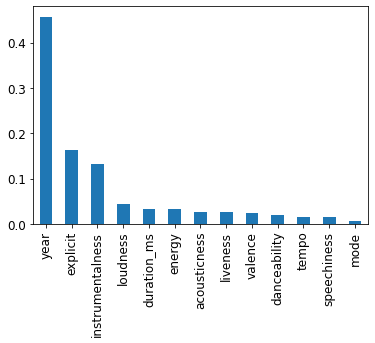

time: 200 ms (started: 2021-02-10 00:57:27 +00:00)


In [ ]:
atributos.remove("popularity_cat")
feat_importances = pd.Series(feature_importances, index=atributos)
feat_importances.nlargest(20).plot(kind='bar')
plt.show()

# **6 - Teste final e estimativa do erro de generalização**

Faremos agora uma medida final da performance do modelo.

Vale lembrar que o GridSearch que realizamos não necessariamente reflete uma situação real, em que há muito mais tempo e recursos para tal processo. Ou seja, uma busca de parâmetros mais completa (usando também outras ferramentas) seria uma ótima opção para melhorar ainda mais o modelo. 

In [ ]:
model = grid_search.best_estimator_

X_test = strat_test_set
y_test = strat_test_set['popularity'].copy()

X_test_tratado_array = pipe.transform(X_test)
X_test_tratado_df = pd.DataFrame(X_test_tratado_array)
predictions = model.predict(X_test_tratado_df)

final_mse = MSE(y_test, predictions)
final_rmse = np.sqrt(final_mse)

drop- completo
time: 211 ms (started: 2021-02-10 01:02:52 +00:00)


In [ ]:
final_rmse

12.881377392285577

time: 6.28 ms (started: 2021-02-10 01:02:54 +00:00)


O _score_ obtido indica que conseguimos melhorar o modelo através da seleção de bons hiperparâmetros.

Quais seriam possíveis melhorias para o projeto?




1.   Obter mais dados e repetir o processo, dando mais atenção à busca por hiperparâmetros.
2.   Tentar introduzir mais _features_ ao modelo, como gêneros musicais e artistas. Preferencialmente sem aumentar de maneira excessiva a dimensão do modelo. 
3.   Determinar se as estimativas do Spotify são confiáveis e/ou úteis. É possível que algumas delas estejam apenas introduzindo "ruído" ao modelo.





